In [1]:
from __future__ import annotations

import hist
import numpy as np

%load_ext autoreload
%autoreload 2

In [9]:
# plot_dir = "plots/PostProcess/24June19Pt300250VBFRun3SaveArrays/"
# plot_dir = "plots/PostProcess/24Oct23Reproduce/"
# plot_dir = "plots/PostProcess/24Oct25GloParTv2/"
# plot_dir = "plots/PostProcess/24Nov8GloParTv2"  # using old bdt disc
# plot_dir = "plots/PostProcess/24Nov9GloParTv2" # using bdt probs
plot_dir = "/home/users/woodson/HH4b/plots/PostProcess/25Feb10GloParTv2BDTv13"
category = "bin1"
mass_window = [110, 155]
arrays_file = f"{plot_dir}/fom_{category}_abcd_mass{mass_window[0]}-{mass_window[1]}_fom_arrays.npz"

bdt_min = 0
bdt_max = 1.0
xbb_min = 0
xbb_max = 1.0

In [10]:
with np.load(arrays_file) as f:
    all_fom = f["all_fom"]
    all_s = f["all_s"]
    all_b = f["all_b"]
    all_b_unc = f["all_b_unc"]
    all_sideband_events = f["all_sideband_events"]
    all_bdt_cuts = f["all_bdt_cuts"]
    all_xbb_cuts = f["all_xbb_cuts"]

In [11]:
bdt_cuts = np.sort(np.unique(all_bdt_cuts))
xbb_cuts = np.sort(np.unique(all_xbb_cuts))

bdt_cuts = np.array([bdt_cut for bdt_cut in bdt_cuts if bdt_cut >= bdt_min and bdt_cut <= bdt_max])
xbb_cuts = np.array([xbb_cut for xbb_cut in xbb_cuts if xbb_cut >= xbb_min and xbb_cut <= xbb_max])

In [12]:
h_sb = hist.Hist(
    hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
    hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
)

h_b = hist.Hist(
    hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
    hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
)

h_s = hist.Hist(
    hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
    hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
)

h_b_unc = hist.Hist(
    hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
    hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
)

h_sideband = hist.Hist(
    hist.axis.Variable(list(bdt_cuts), name="bdt_cut"),
    hist.axis.Variable(list(xbb_cuts), name="xbb_cut"),
)

In [13]:
for xbb_cut in xbb_cuts:
    for bdt_cut in bdt_cuts:
        # find index of this cut
        idx = np.where((all_bdt_cuts == bdt_cut) & (all_xbb_cuts == xbb_cut))[0][0]
        if all_s[idx] > 0.5 and all_b[idx] >= 2 and all_sideband_events[idx] >= 12:
            h_sb.fill(bdt_cut, xbb_cut, weight=all_fom[idx])
            h_b.fill(bdt_cut, xbb_cut, weight=all_b[idx])
            h_b_unc.fill(bdt_cut, xbb_cut, weight=all_b_unc[idx])
            h_sideband.fill(bdt_cut, xbb_cut, weight=all_sideband_events[idx])
            h_s.fill(bdt_cut, xbb_cut, weight=all_s[idx])

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep
from tqdm import tqdm

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

mpl.rcParams["font.size"] = 30
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.dpi"] = 400
mpl.rcParams["figure.edgecolor"] = "none"

plt.style.use(hep.style.CMS)
hep.style.use("CMS")


def plot_fom(h_sb, plot_dir, name="figofmerit", show=False, fontsize=3.5, label="Fig Of Merit"):
    """Plot FoM scan"""

    eff, bins_x, bins_y = h_sb.to_numpy()
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    plt.rcParams.update({"font.size": 18})

    cbar = hep.hist2dplot(
        h_sb, ax=ax, cmin=np.min(eff[eff > 0]) * 0.75, cmax=np.max(eff[eff > 0]) * 1.25, flow="none"
    )
    cbar.cbar.set_label(label, size=18)
    cbar.cbar.ax.get_yaxis().labelpad = 15
    for i in tqdm(range(len(bins_x) - 1)):
        for j in range(len(bins_y) - 1):
            if eff[i, j] > 0:
                ax.text(
                    (bins_x[i] + bins_x[i + 1]) / 2,
                    (bins_y[j] + bins_y[j + 1]) / 2,
                    eff[i, j].round(1),
                    color="black",
                    ha="center",
                    va="center",
                    fontsize=fontsize,
                )

    ax.set_xlabel("BDT Cut")
    ax.set_ylabel(r"$T_{Xbb}$ Cut")
    ax.set_ylim(bins_y[0], bins_y[-1])
    ax.set_xlim(bins_x[0], bins_x[-1])
    fig.tight_layout()
    plt.savefig(f"{plot_dir}/{name}.png", bbox_inches="tight")
    plt.savefig(f"{plot_dir}/{name}.pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.90it/s]


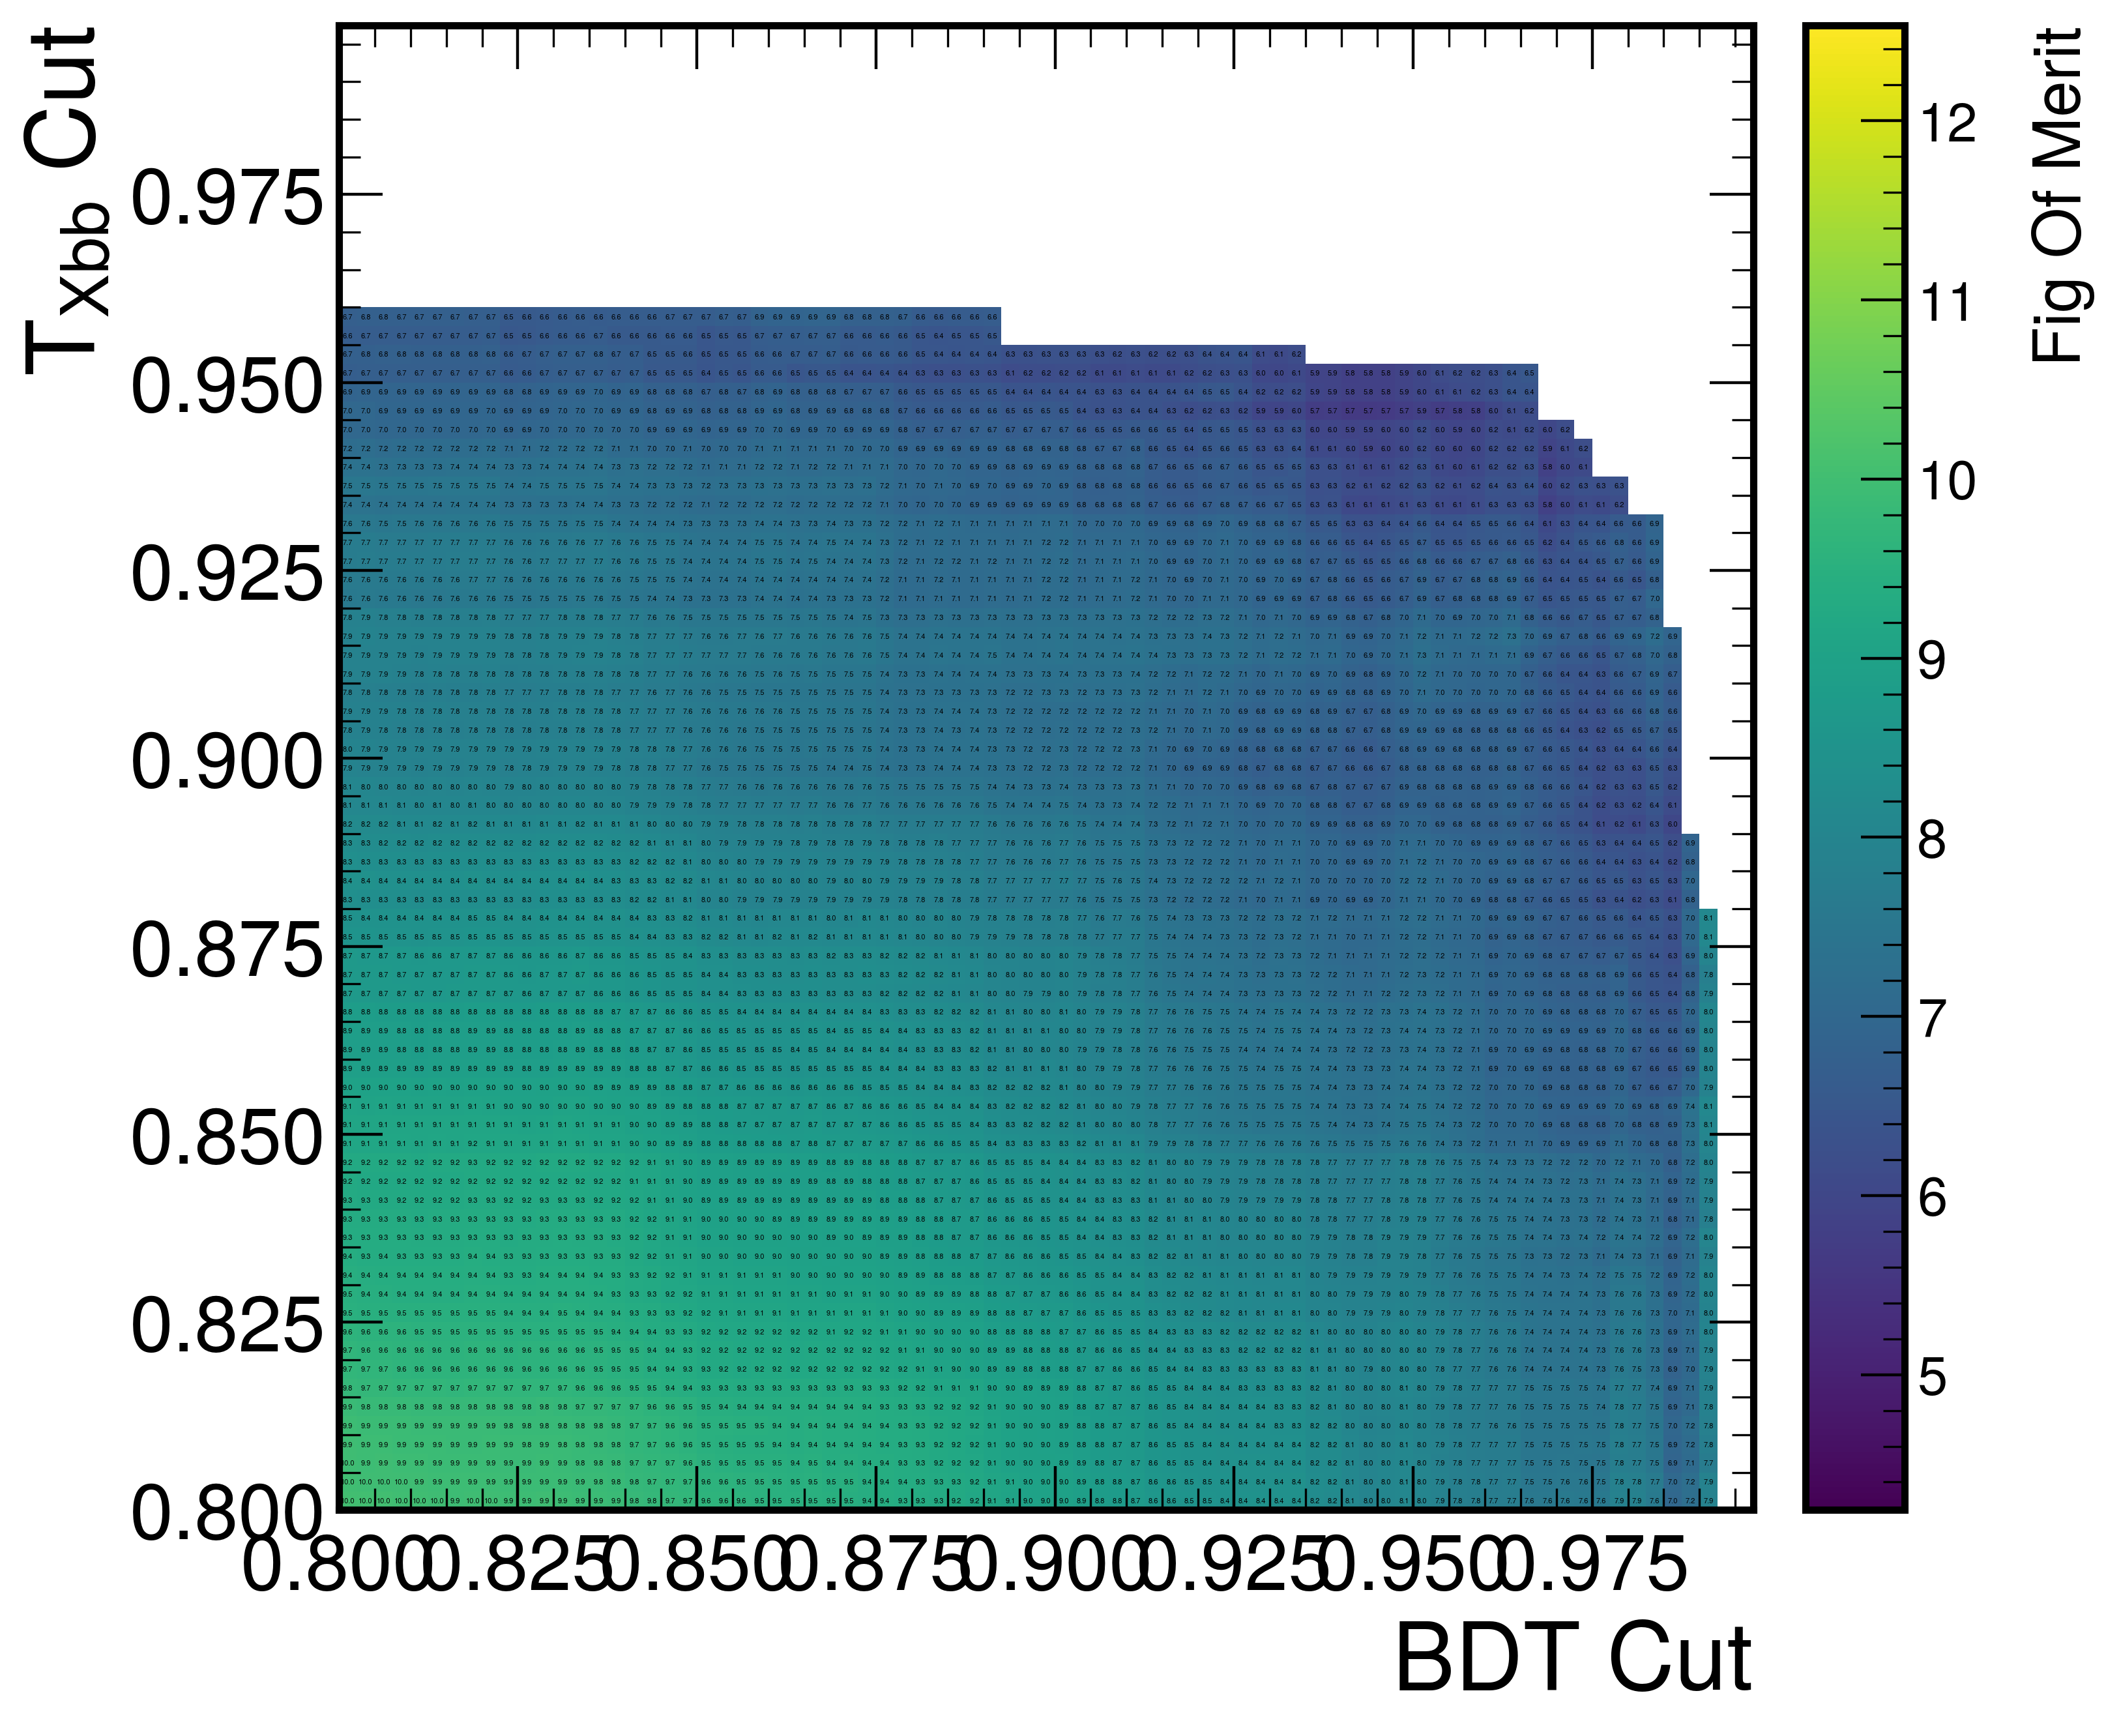

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.03it/s]


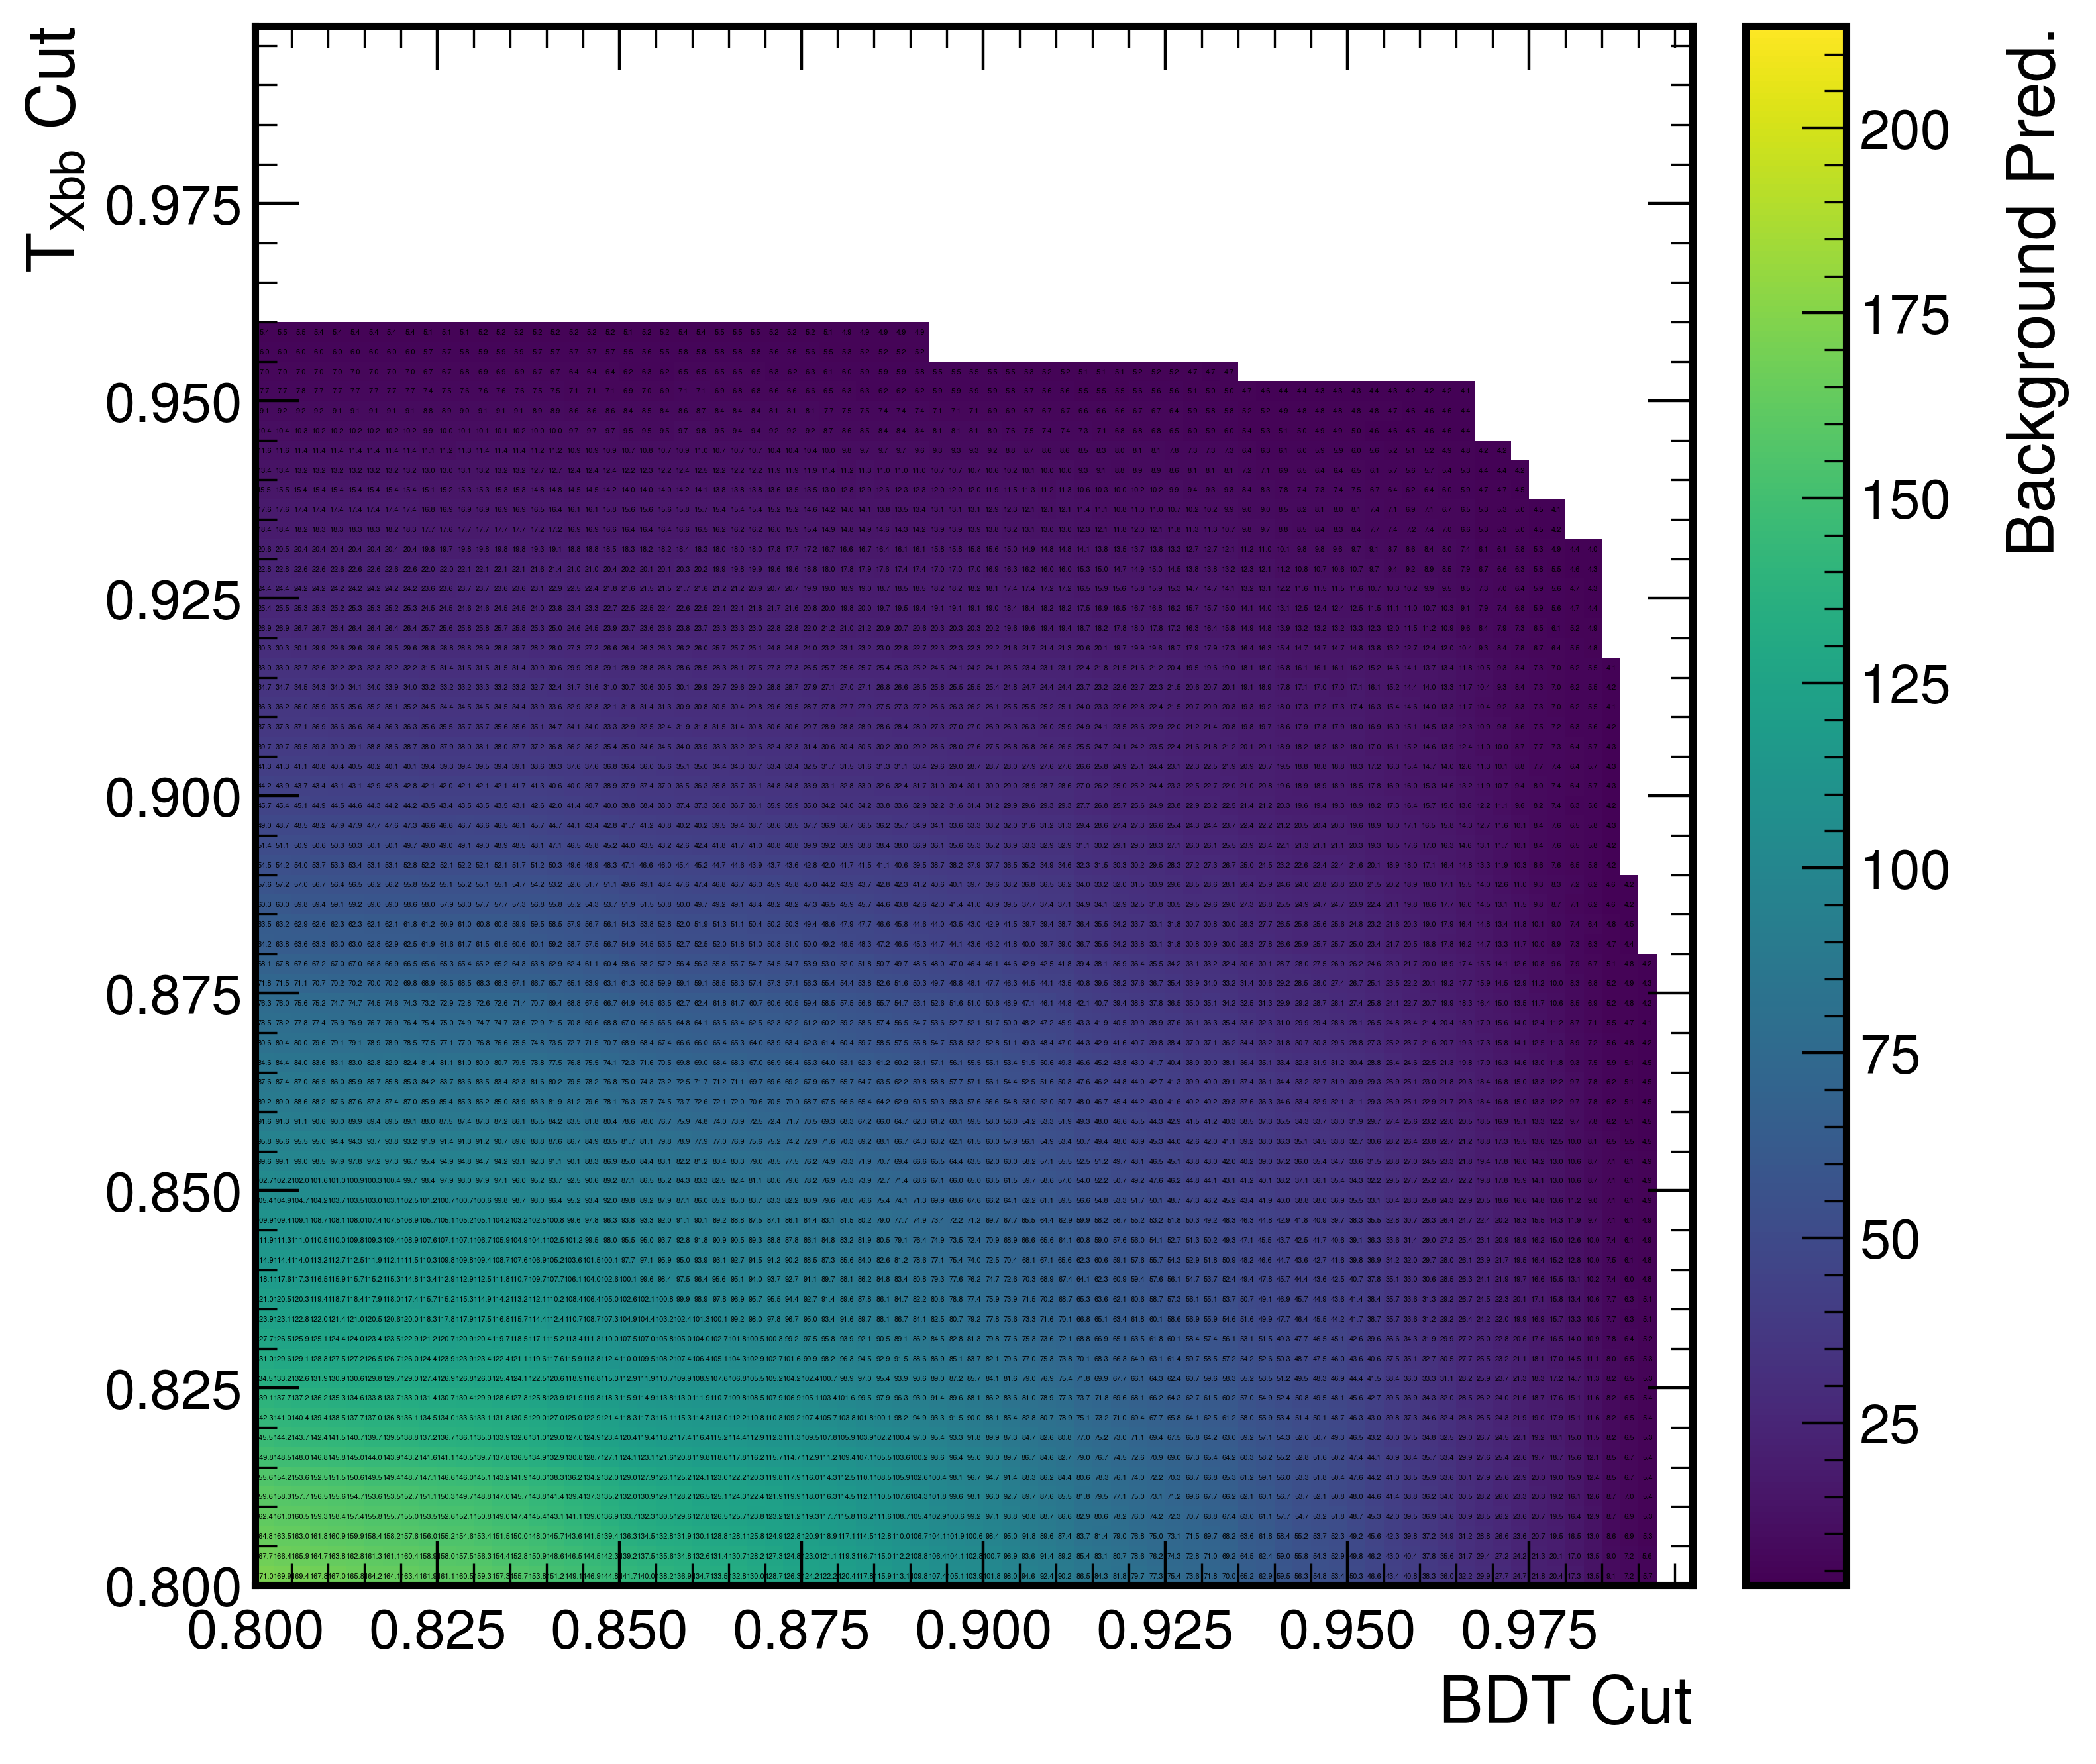

In [15]:
name = f"fom_{category}_abcd_mass{mass_window[0]}-{mass_window[1]}"
plot_fom(h_sb, plot_dir, name=name, fontsize=2.0, show=True, label="Fig Of Merit")
if category == "bin1":
    plot_fom(h_b, plot_dir, name=f"{name}_bkg", fontsize=2.0, show=True, label="Background Pred.")
# plot_fom(h_b_unc, plot_dir, name=f"{name}_bkgunc", fontsize=2.0, show=True, label="Background Unc.")
# plot_fom(
#     h_sideband, plot_dir, name=f"{name}_sideband", fontsize=2.0, show=True, label="Sideband Events"
# )
# plot_fom(h_s, plot_dir, name=f"{name}_signal", fontsize=2.0, show=True, label="Signal Pred.")

In [16]:
masked_h_sb = np.ma.masked_equal(h_sb.values(), 0)

global_min = np.min(masked_h_sb)

masked_h_sb_min_diff = np.abs(masked_h_sb - global_min)

argmin_axis0 = np.argmin(masked_h_sb_min_diff, axis=0)
min_axis0 = np.min(masked_h_sb_min_diff, axis=0)

argmin_axis1 = np.argmin(masked_h_sb_min_diff, axis=1)
min_axis1 = np.min(masked_h_sb_min_diff, axis=1)

bdt_cut = h_sb.axes[0].edges[argmin_axis0[min_axis0 == 0]]
xbb_cut = h_sb.axes[1].edges[argmin_axis1[min_axis1 == 0]]

print(f"Category: {category}")
print(f"FoM: {global_min}")
print(f"BDT cut: {bdt_cut}")
print(f"TXbb cut: {xbb_cut}")

Category: bin1
FoM: 5.658252871583994
BDT cut: [0.94]
TXbb cut: [0.945]


python3 PostProcess.py \
--templates-tag 25Feb10GloParTv2BDTv13 \
--tag 24Sep25_v12v2_private_signal \
--mass H2PNetMass \
--txbb glopart-v2 \
--bdt-config v13_glopartv2 \
--bdt-model 25Feb5_v13_glopartv2_rawmass \
--txbb-wps 0.945 0.85 \
--bdt-wps 0.94 0.755 0.03 \
--vbf \
--no-vbf-priority \
--vbf-txbb-wp 0.8 \
--vbf-bdt-wp 0.9825 \
--no-fom-scan \
--data-dir /ceph/cms/store/user/cmantill/bbbb/skimmer/ \
--method abcd \
--pt-second 250 \
--pt-first 300 \
--templates


python3 PostProcess.py \
--templates-tag 25Feb10GloParTv2BDTv13CHECK \
--tag 24Sep25_v12v2_private_signal \
--mass H2PNetMass \
--txbb glopart-v2 \
--bdt-config v13_glopartv2 \
--bdt-model 25Feb5_v13_glopartv2_rawmass \
--txbb-wps 0.945 0.85 \
--bdt-wps 0.94 0.755 0.03 \
--vbf \
--no-vbf-priority \
--vbf-txbb-wp 0.8 \
--vbf-bdt-wp 0.9825 \
--fom-scan \
--no-fom-scan-bin1 \
--fom-scan-vbf \
--no-fom-scan-bin2 \
--data-dir /ceph/cms/store/user/cmantill/bbbb/skimmer/ \
--method abcd \
--pt-second 250 \
--pt-first 300 \
--no-templates